In [1]:
li#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
import random
from matplotlib.colors import DivergingNorm
li
#0-1 normalisation
from sklearn import preprocessing

from scipy.stats import pearsonr
import scipy.stats as stats

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import cleaning_processing, HenDailyVariable_Origins
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
random.seed(0)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
dico_matching = config.dico_matching
dico_night_hour = config.dico_night_hour
dico_garden_opening_hour = config.dico_garden_opening_hour
pal_zone = config.pal_zone
pal_pens = config.pal_pens
pal_tracking_system = config.pal_tracking_system
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path_extracted_data_cleaning_rawvscleaned = os.path.join(path_extracted_data_cleaning,'Raw&Cleaned')  
path_extracted_data_cleaning_rawvscleaned_DF = os.path.join(path_extracted_data_cleaning_rawvscleaned,'var_expl')
if not os.path.exists(path_extracted_data_cleaning_rawvscleaned_DF):
    os.makedirs(path_extracted_data_cleaning_rawvscleaned_DF)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [5]:
#for being more reproductible, we open the file that was saved from cleaning
df_var = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'daily_ALL_variables.csv'), sep=';', 
                 parse_dates=['level'], dayfirst=True) 
print(df_var.shape)
dico_pen_ts = {3:'TrackingSystem 3-5',
              4:'TrackingSystem 3-5',
              5:'TrackingSystem 3-5',
              8:'TrackingSystem 8-9',
              9:'TrackingSystem 8-9',
              10:'TrackingSystem 10-12',
              11:'TrackingSystem 10-12',
              12:'TrackingSystem 10-12'}
df_var['tracking_system'] = df_var['PenID'].map(lambda x: dico_pen_ts[x])
df_var['PenID'] = df_var['PenID'].map(lambda x: 'Pen '+str(int(x)))
#df_var[(df_var['HenID']=='hen_101') & (df_var['level']==dt.datetime(2020,11,2))]
print('You are analysing %d days'%len(df_var['level'].unique()))
df_var.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27888, 118)
You are analysing 83 days


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,temperature_night20_2_median,temperature_night20_2_max,temperature_night20_2_var,list_of_MovementCounter_day,len_MovementCounter_day,MovementCounter_day_amount_nnactivity,MovementCounter_day_max,MovementCounter_day_mean,type,tracking_system
0,hen_131,2020-10-27,2258.0,19888.0,16978.0,3204.0,872.0,43200.0,"[2258.0, 19888.0, 16978.0, 3204.0, 872.0]","[0.05226851851851852, 0.4603703703703704, 0.39...",...,29.0,30.0,0.212191,"[41.0, 62.0, 72.0, 71.0, 63.0, 50.0, 36.0, 39....",72.0,0.000000,103.0,67.236111,cleaning,TrackingSystem 10-12
1,hen_131,2020-10-28,3643.0,19470.0,17180.0,2504.0,403.0,43200.0,"[3643.0, 19470.0, 17180.0, 2504.0, 403.0]","[0.0843287037037037, 0.45069444444444445, 0.39...",...,29.0,29.0,0.212191,"[45.0, 78.0, 59.0, 64.0, 52.0, 43.0, 43.0, 55....",72.0,0.000000,109.0,69.138889,cleaning,TrackingSystem 10-12
2,hen_131,2020-10-29,2642.0,21300.0,19136.0,2727.0,995.0,46800.0,"[2642.0, 21300.0, 19136.0, 2727.0, 995.0]","[0.05645299145299145, 0.4551282051282051, 0.40...",...,29.0,29.0,0.076389,"[18.0, 30.0, 30.0, 65.0, 48.0, 44.0, 66.0, 61....",78.0,0.012821,108.0,69.333333,cleaning,TrackingSystem 10-12


In [6]:
len(df_var['verification_daily_total_duration'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


27888

In [7]:
np.nanmean(df_var['Total_number_transition'].tolist()), np.nanmedian(df_var['Total_number_transition'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(64.31930459408433, 63.0)

# Save dataframe for modelling in R

In [8]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
display(df_var[['HenID','PenID','level', 'tracking_system', 'type']+li_var].head(3))
#put all bouts into a columns
#restrict to the same amount of day light
print(df_var.shape)
df_plt = df_var[df_var['verification_daily_total_duration']==54000]
print(df_plt.shape)
df_plt = pd.melt(df_plt, id_vars=['level', 'HenID', 'PenID', 'tracking_system', 'type'], value_vars=li_var)
df_plt.rename(columns={'variable':'Trackingsystem_Zone', 'value':'nbr_of_stay'}, inplace=True)
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['level','HenID','PenID','tracking_system','Trackingsystem_Zone'], 
                      columns='type',values='nbr_of_stay').reset_index()
print(df_plt.shape)
df_plt = df_plt[~df_plt.isnull().any(axis=1)]
print(df_plt.shape)
display(df_plt.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,level,tracking_system,type,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
0,hen_131,Pen 10,2020-10-27,TrackingSystem 10-12,cleaning,8.0,24.0,25.0,9.0,1.0
1,hen_131,Pen 10,2020-10-28,TrackingSystem 10-12,cleaning,9.0,25.0,19.0,4.0,1.0
2,hen_131,Pen 10,2020-10-29,TrackingSystem 10-12,cleaning,8.0,25.0,29.0,13.0,2.0


(27888, 119)
(16390, 119)


,level,HenID,PenID,tracking_system,type,Trackingsystem_Zone,nbr_of_stay
0,2020-11-26,hen_131,Pen 10,TrackingSystem 10-12,cleaning,nbr_stays_1_Zone,3.0
1,2020-11-27,hen_131,Pen 10,TrackingSystem 10-12,cleaning,nbr_stays_1_Zone,5.0
2,2020-11-28,hen_131,Pen 10,TrackingSystem 10-12,cleaning,nbr_stays_1_Zone,4.0


(40975, 7)
(40975, 7)


type,level,HenID,PenID,tracking_system,Trackingsystem_Zone,cleaning,raw
0,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_1_Zone,3.0,9.0
1,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_2_Zone,16.0,22.0
2,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_3_Zone,14.0,21.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


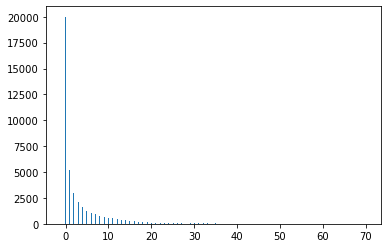

In [9]:
df_plt['Difference_r-cl'] = df_plt.apply(lambda x: x['raw']-x['cleaning'], axis=1)
plt.hist(df_plt['Difference_r-cl'].dropna(),bins='auto');

In [10]:
df_plt[df_plt['Difference_r-cl']<0] 
#checked manually: when the model remove the last transtion of the night, then the bird will start his day / first stay in a 
#different zone, which at the end can be adding a stay in this zone.

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type,level,HenID,PenID,tracking_system,Trackingsystem_Zone,cleaning,raw,Difference_r-cl
24019,2020-12-27,hen_173,Pen 8,TrackingSystem 8-9,nbr_stays_5_Zone,7.0,6.0,-1.0


In [11]:
df_plt['absolute_difference'] = df_plt['Difference_r-cl'].map(lambda x: abs(x))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
#keep hens that have more than 70 days
df_ = df_plt.groupby(['HenID'])['level'].agg(lambda x: len(set(x))).reset_index()
df_['has_more_70days'] = df_['level'].map(lambda x: x>=50)
li_hen2keep = df_[df_['has_more_70days']]['HenID'].unique()
print(df_plt.shape, df_plt[df_plt['HenID'].isin(li_hen2keep)].shape)
df_plt = df_plt[df_plt['HenID'].isin(li_hen2keep)]
df_.head(3)

(40975, 9) (40735, 9)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,has_more_70days
0,hen_1,52,True
1,hen_10,51,True
2,hen_101,51,True


In [13]:
len(df_plt['HenID'].unique()), len(df_plt['level'].unique())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(159, 52)

In [14]:
m = df_plt['level'].min()
df_plt['level_continuous'] = df_plt['level'].map(lambda x: (x-m).days)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
#add weather as environemntal factor
path_ = r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather'
path_weather = os.path.join(path_,'df_daily_weather.csv')
df_weather = pd.read_csv(path_weather, sep=';', parse_dates=['date'])
print(df_weather.shape)
df_weather.head(3)

(133, 4)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,temperature_C,humidity_avgpercent,had_rainorsnow
0,2020-09-29,12.000,92.125,0
1,2020-09-30,12.250,80.125,1
2,2020-10-01,14.125,74.875,0


In [16]:
print(df_plt.shape)
df_plt = pd.merge(df_plt, df_weather, right_on='date', left_on='level', how='left')
print(df_plt.shape)
df_plt.head(3)

(40735, 10)
(40735, 14)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,HenID,PenID,tracking_system,Trackingsystem_Zone,cleaning,raw,Difference_r-cl,absolute_difference,level_continuous,date,temperature_C,humidity_avgpercent,had_rainorsnow
0,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_1_Zone,3.0,9.0,6.0,6.0,0,2020-11-26,2.5,91.25,1
1,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_2_Zone,16.0,22.0,6.0,6.0,0,2020-11-26,2.5,91.25,1
2,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_3_Zone,14.0,21.0,7.0,7.0,0,2020-11-26,2.5,91.25,1


In [17]:
#all observations over the 52 days
#add useful var for model
df_plt['Local_locations'] = df_plt.apply(lambda x: x['PenID']+'_'+x['Trackingsystem_Zone'], axis=1)
#add the total number of movement over the day
df_tr = df_var[(df_var['HenID'].isin(df_plt['HenID'].unique()))&\
               (df_var['type']=='cleaning')].groupby(['level'])['Total_number_transition'].sum().reset_index()
df_tr.head(3)
df_plt = pd.merge(df_plt, df_tr, on=['level'], how='left')
display(df_plt.head(3))
display(df_plt.tail(3))
df_plt = df_plt.reset_index(drop=True)
li_modelVAR =  ['absolute_difference', 'PenID','tracking_system','Trackingsystem_Zone','HenID','level','level_continuous',
              'temperature_C','humidity_avgpercent','had_rainorsnow','Total_number_transition']
df_plt.filter(li_modelVAR).to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                               'df4DifferenceModelling.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,HenID,PenID,tracking_system,Trackingsystem_Zone,cleaning,raw,Difference_r-cl,absolute_difference,level_continuous,date,temperature_C,humidity_avgpercent,had_rainorsnow,Local_locations,Total_number_transition
0,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_1_Zone,3.0,9.0,6.0,6.0,0,2020-11-26,2.5,91.25,1,Pen 9_nbr_stays_1_Zone,8368.0
1,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_2_Zone,16.0,22.0,6.0,6.0,0,2020-11-26,2.5,91.25,1,Pen 9_nbr_stays_2_Zone,8368.0
2,2020-11-26,hen_1,Pen 9,TrackingSystem 8-9,nbr_stays_3_Zone,14.0,21.0,7.0,7.0,0,2020-11-26,2.5,91.25,1,Pen 9_nbr_stays_3_Zone,8368.0


,level,HenID,PenID,tracking_system,Trackingsystem_Zone,cleaning,raw,Difference_r-cl,absolute_difference,level_continuous,date,temperature_C,humidity_avgpercent,had_rainorsnow,Local_locations,Total_number_transition
40732,2021-01-18,hen_99,Pen 11,TrackingSystem 10-12,nbr_stays_3_Zone,16.0,16.0,0.0,0.0,53,2021-01-18,2.25,73.5,1,Pen 11_nbr_stays_3_Zone,3521.0
40733,2021-01-18,hen_99,Pen 11,TrackingSystem 10-12,nbr_stays_4_Zone,7.0,7.0,0.0,0.0,53,2021-01-18,2.25,73.5,1,Pen 11_nbr_stays_4_Zone,3521.0
40734,2021-01-18,hen_99,Pen 11,TrackingSystem 10-12,nbr_stays_5_Zone,4.0,4.0,0.0,0.0,53,2021-01-18,2.25,73.5,1,Pen 11_nbr_stays_5_Zone,3521.0


In [18]:
#subset: 40 hens over 50 days: less degree of freedom
random.seed(0)
#randomly pick more than one element from the list without repeating elements
df_rs = df_plt.groupby(['PenID'])['HenID'].agg(lambda x: set(x)).reset_index()
df_rs['random_selected'] = df_rs['HenID'].map(lambda x: random.sample(x, 5))
li_selected = [j for i in df_rs['random_selected'].tolist() for j in i]
display(df_rs.head(3))
df_plt_ = df_plt[df_plt['HenID'].isin(li_selected)].copy()
df_plt_.drop(['Total_number_transition'], axis=1, inplace=True)
#add the total number of movement over the day
df_tr = df_var[(df_var['HenID'].isin(li_selected))&(df_var['type']=='cleaning')].groupby(['level'])['Total_number_transition'].sum().reset_index()
df_plt_ = pd.merge(df_plt_, df_tr, on=['level'], how='left')
display(df_plt_.head(3))
df_plt_.filter(li_modelVAR).to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                                                'df4DifferenceModelling_4lowerDF.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,HenID,random_selected
0,Pen 10,"{hen_140, hen_57, hen_78, hen_141, hen_131, he...","[hen_49, hen_177, hen_57, hen_54, hen_193]"
1,Pen 11,"{hen_87, hen_6, hen_112, hen_28, hen_84, hen_1...","[hen_111, hen_14, hen_118, hen_165, hen_39]"
2,Pen 12,"{hen_68, hen_159, hen_149, hen_42, hen_197, he...","[hen_76, hen_197, hen_135, hen_45, hen_122]"


,level,HenID,PenID,tracking_system,Trackingsystem_Zone,cleaning,raw,Difference_r-cl,absolute_difference,level_continuous,date,temperature_C,humidity_avgpercent,had_rainorsnow,Local_locations,Total_number_transition
0,2020-11-26,hen_102,Pen 3,TrackingSystem 3-5,nbr_stays_1_Zone,2.0,3.0,1.0,1.0,0,2020-11-26,2.5,91.25,1,Pen 3_nbr_stays_1_Zone,2152.0
1,2020-11-26,hen_102,Pen 3,TrackingSystem 3-5,nbr_stays_2_Zone,6.0,7.0,1.0,1.0,0,2020-11-26,2.5,91.25,1,Pen 3_nbr_stays_2_Zone,2152.0
2,2020-11-26,hen_102,Pen 3,TrackingSystem 3-5,nbr_stays_3_Zone,8.0,8.0,0.0,0.0,0,2020-11-26,2.5,91.25,1,Pen 3_nbr_stays_3_Zone,2152.0


#mixing HenID
random.seed(0)
df_plt_mix = df_plt.copy()
li_all_hen = set(df_plt['HenID'].unique())
df_plt_mix['HenID'] = df_plt_mix['HenID'].map(lambda x: random.sample(li_all_hen, 1)[0])
df_plt_mix.filter(li_modelVAR).to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                                                'df4DifferenceModelling_mixedHenID.csv'), index=False, sep=';')

#add pen as integer: indicator of how close it is to the door
df_plt_door = df_plt.copy()
df_plt_door['PenID'] = df_plt_door['PenID'].map(lambda x: int(x.split(' ')[1]))
df_plt_door.filter(li_modelVAR).to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                                                'df4DifferenceModelling_door.csv'), index=False, sep=';')

# Scatter plot: per zone, tracking systems, pens OVER ENTIRE PERIOD

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,level,tracking_system,type,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
0,hen_131,Pen 10,2020-10-27,TrackingSystem 10-12,cleaning,8.0,24.0,25.0,9.0,1.0
1,hen_131,Pen 10,2020-10-28,TrackingSystem 10-12,cleaning,9.0,25.0,19.0,4.0,1.0
2,hen_131,Pen 10,2020-10-29,TrackingSystem 10-12,cleaning,8.0,25.0,29.0,13.0,2.0


,level,HenID,PenID,tracking_system,type,Trackingsystem_Zone,nbr_of_stay
0,2020-10-27,hen_131,Pen 10,TrackingSystem 10-12,cleaning,nbr_stays_1_Zone,8.0
1,2020-10-28,hen_131,Pen 10,TrackingSystem 10-12,cleaning,nbr_stays_1_Zone,9.0
2,2020-10-29,hen_131,Pen 10,TrackingSystem 10-12,cleaning,nbr_stays_1_Zone,8.0


(69720, 7)
(63560, 7)


type,level,HenID,PenID,tracking_system,Trackingsystem_Zone,cleaning,raw
240,2020-10-27,hen_10,Pen 11,TrackingSystem 10-12,nbr_stays_1_Zone,0.0,0.0
241,2020-10-27,hen_10,Pen 11,TrackingSystem 10-12,nbr_stays_2_Zone,2.0,2.0
242,2020-10-27,hen_10,Pen 11,TrackingSystem 10-12,nbr_stays_3_Zone,9.0,9.0


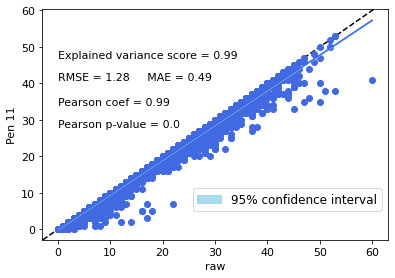

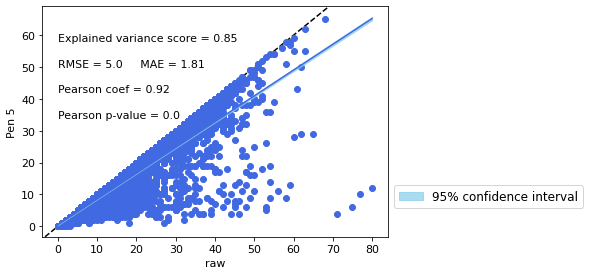

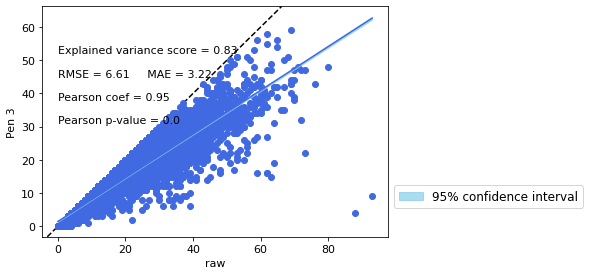

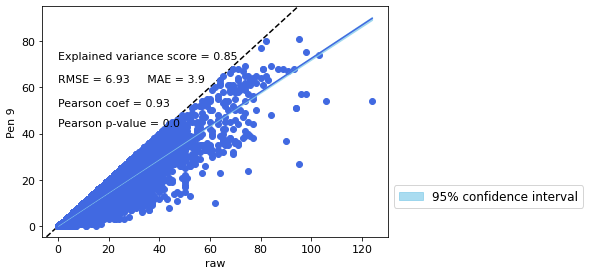

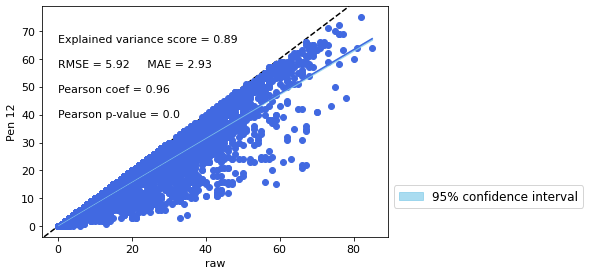

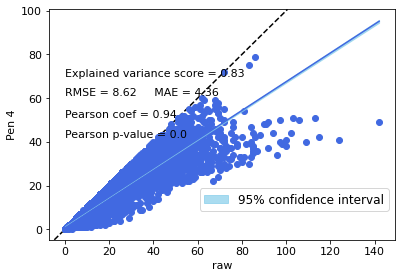

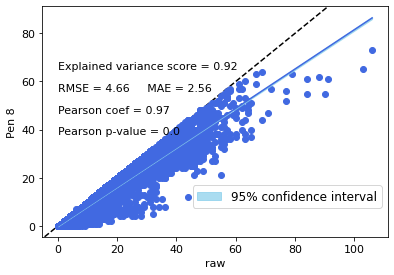

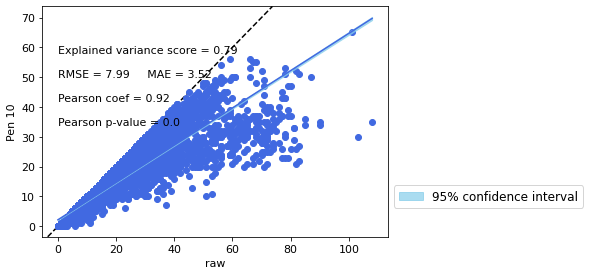

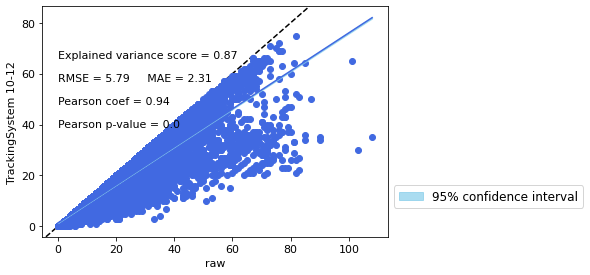

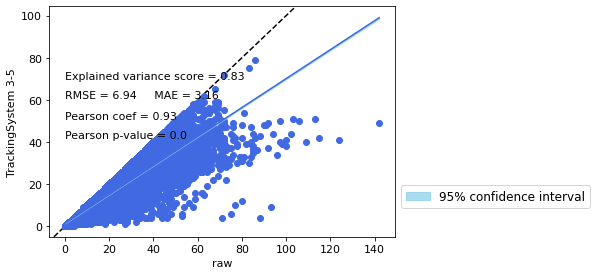

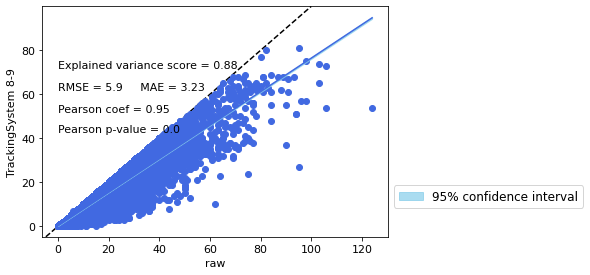

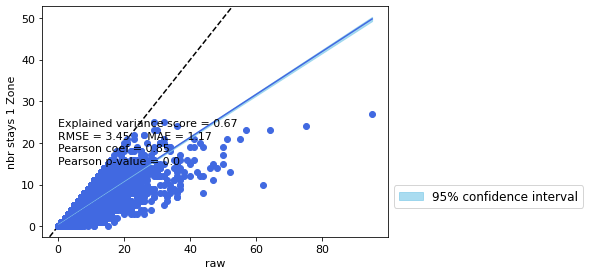

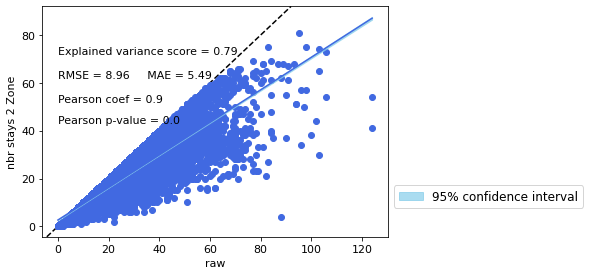

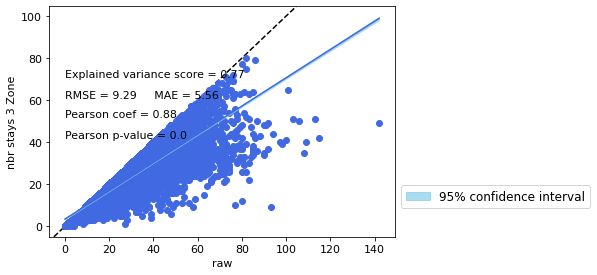

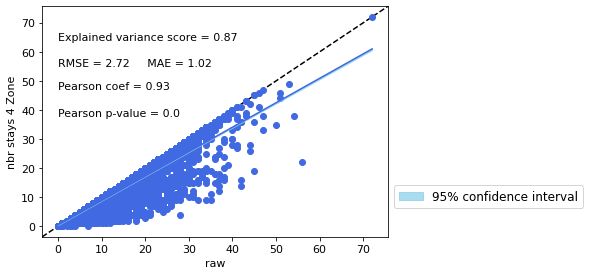

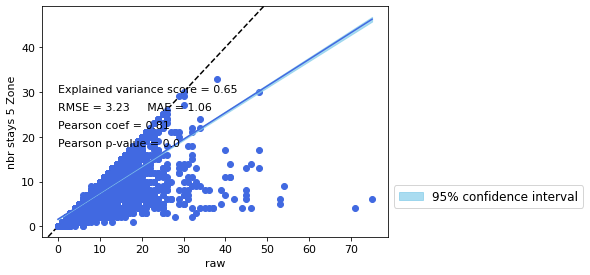

In [59]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
display(df_var[['HenID','PenID','level', 'tracking_system', 'type']+li_var].head(3))
#put all bouts into a columns
df_plt = pd.melt(df_var, id_vars=['level', 'HenID', 'PenID', 'tracking_system', 'type'], value_vars=li_var)
df_plt.rename(columns={'variable':'Trackingsystem_Zone', 'value':'nbr_of_stay'}, inplace=True)
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['level','HenID','PenID','tracking_system','Trackingsystem_Zone'], 
                      columns='type',values='nbr_of_stay').reset_index()
print(df_plt.shape)
df_plt = df_plt[~df_plt.isnull().any(axis=1)]
print(df_plt.shape)
display(df_plt.head(3))

for type_ in ['PenID','tracking_system','Trackingsystem_Zone']:
    for y_ in df_plt[type_].unique():

        #data
        x = np.array(df_plt[df_plt[type_]==y_]['raw'].tolist())
        y = np.array(df_plt[df_plt[type_]==y_]['cleaning'].tolist())

        #measures
        Explvarscore = explained_variance_score(x, y)
        RMSE = math.sqrt(mean_squared_error(x, y))
        MAE = mean_absolute_error(x, y)
        rcoeff2, p_value2 = pearsonr(x, y)

        #linear model & it's the 95% CI
        slope, intercept = np.polyfit(x, y, 1) #degree=1: fit a linear model
        y_model = np.polyval([slope, intercept], x) #evaluate the y_pred by the model
        x_mean = np.mean(x) ; y_mean = np.mean(y)
        n = x.size                        # number of samples
        dof = n - 2                       # degrees of freedom: size-#parameters
        t_ = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
        residual = y - y_model

        ############### Plot
        plt.rcParams.update({'font.size': 11})
        fig = plt.figure()
        ax = fig.add_axes([.1, .1, .8, .8])

        #plot points with size equal to the amount of points (as count data)
        # count the occurrences of each point
        #c = Counter(zip(x,y))
        # create a list of the sizes, here multiplied by 10 for scale
        #s = [10*c[(xx,yy)] for xx,yy in zip(x,y)]
        #ax.scatter(x, y, s=s, color = 'royalblue')
        ax.scatter(x, y, color = 'royalblue')

        #plot middle line and 95% IC
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = np.polyval([slope, intercept], x_line)
        # confidence interval
        std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error
        ci = t_ * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
        ax.plot(x_line, y_line, color = 'royalblue')
        ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval', alpha=0.7)

        #add text
        ax.set_xlabel('raw')
        ax.set_ylabel(y_.replace('_',' '))
        epsi=0
        #if y_=='Model_Zone':
        #   epsi = 0.5
        ax.text(0, max(y)-int(0.12*max(y))+epsi, 'Explained variance score = ' + str(np.round(Explvarscore,2)))
        ax.text(0, max(y)-int(0.24*max(y))+epsi, 'RMSE = ' + str(np.round(RMSE,2)) +\
                                            '     MAE = ' + str(np.round(MAE,2)))
        ax.text(0, max(y)-int(0.36*max(y))+epsi, 'Pearson coef = ' + str(np.round(rcoeff2,2)))
        ax.text(0, max(y)-int(0.48*max(y))+epsi, 'Pearson p-value = ' + str(np.round(p_value2,2)))
        plt.legend(bbox_to_anchor=(1, .25), fontsize=12);

        #add diagonal line
        ax.axline((0, 0), slope=1, c="black", ls="--", zorder=0)

        #sae and show
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, "NbrStay_"+y_+".png"),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show();

# Per hens, zones, tracking systems, pens OVER DIFFERENT AMOUNT OF DAYS

In [60]:
#at each day the percentage of wrong transition
#to avoid impact of time on the mvt of the chicken, we will selcted the days randomly across all possible days, and do several
#such plot to see if the patterns is still the same, but we dont aggregate all as the more the nbr of days increase, the least
#possibilities exists, and hence less variation by definition
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
df_ = df_var[['HenID','level','type']+li_var]
df_ = df_[~df_.isnull().any(axis=1)]
max_nbr_days = 35

dico_hen_days = dict(df_.groupby(['HenID'])['level'].count())
li_hen = [h for h,nbrdays in dico_hen_days.items() if nbrdays>max_nbr_days]
print('We have %s hens with at least %s days'%(len(li_hen), max_nbr_days))
df_ = df_[df_['HenID'].isin(li_hen)]
#remove all hens with less than this amount of days
display(df_.head(3))
li_df = []
for nbr_days in tqdm.tqdm(range(2,max_nbr_days)):
    for henid,df_h in df_.groupby(['HenID']): 
        #select random days without repeating elements
        li_date = random.sample(df_h['level'].tolist(), nbr_days)
        df_h_ = df_h[df_h['level'].isin(li_date)]
        
        #put all bouts into a columns
        df__ = pd.melt(df_h_, id_vars=['level', 'HenID', 'type'], value_vars=li_var)
        df__.rename(columns={'variable':'Trackingsystem_Zone', 'value':'nbr_bouts'}, inplace=True)
        #display(df__.head(3))
        df__ = df__.pivot(index=['level','HenID','Trackingsystem_Zone'], columns='type', values='nbr_bouts').reset_index()
        #display(df__.head(3))
        li1 = df__['raw']
        li2 = df__['cleaning']
        RMSE = math.sqrt(mean_squared_error(li1, li2))
        MAE = mean_absolute_error(li1, li2)
        #not symmetric measure
        #R2 = r2_score(li1, li2)
        explained_variance = explained_variance_score(li1, li2)
        explained_variance_ = explained_variance_score(li2, li1)

        li_df.append({'HenID':henid, 'RMSE': RMSE, 'MAE':MAE, 'explained_variance':explained_variance,
                      'explained_variance_cl_raw':explained_variance_, 
                      'number of days':nbr_days, 'li_date':li_date, 'nbrObservations':len(li1)})
#small e.g.
#y_true = [1,2,3] ; y_pred = [1,2,3.5]
#print(mean_squared_error(y_true, y_pred),
#      mean_absolute_error(y_true, y_pred),
#      r2_score(y_true, y_pred), #not symmetric
#      explained_variance_score(y_true, y_pred)) #not symetruc
df_impact = pd.DataFrame(li_df)
#add penID and tracking system info
df_ = df_var.groupby(['HenID'])['PenID'].agg(lambda x:  list(set(x))).reset_index()
df_['PenID'] = df_['PenID'].map(lambda x: x[0] if len(x)==1 else 'error')
df_['PenID'].value_counts()
dico_hen_pen = dict(zip(df_['HenID'].tolist(), df_['PenID'].tolist()))
df_impact['PenID'] = df_impact['HenID'].map(lambda x: dico_hen_pen[x])
dico_pen_ts = {'Pen 3':'TrackingSystem 3-5',
              'Pen 4':'TrackingSystem 3-5',
              'Pen 5':'TrackingSystem 3-5',
              'Pen 8':'TrackingSystem 8-9',
              'Pen 9':'TrackingSystem 8-9',
              'Pen 10':'TrackingSystem 10-12',
              'Pen 11':'TrackingSystem 10-12',
              'Pen 12':'TrackingSystem 10-12'}
df_impact['tracking_system'] = df_impact['PenID'].map(lambda x: dico_pen_ts[x])
print(df_impact.shape)
df_impact.head(3)

We have 177 hens with at least 35 days


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,type,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
0,hen_131,2020-10-27,cleaning,8.0,24.0,25.0,9.0,1.0
1,hen_131,2020-10-28,cleaning,9.0,25.0,19.0,4.0,1.0
2,hen_131,2020-10-29,cleaning,8.0,25.0,29.0,13.0,2.0


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:40<00:00,  1.22s/it]

(5841, 10)


,HenID,RMSE,MAE,explained_variance,explained_variance_cl_raw,number of days,li_date,nbrObservations,PenID,tracking_system
0,hen_1,12.437845,10.9,0.803235,0.482032,2,"[2021-01-15 00:00:00, 2020-12-03 00:00:00]",10,Pen 9,TrackingSystem 8-9
1,hen_10,0.447214,0.2,0.998401,0.998368,2,"[2020-11-21 00:00:00, 2020-12-07 00:00:00]",10,Pen 11,TrackingSystem 10-12
2,hen_100,6.276942,2.8,0.200810,-4.358234,2,"[2020-11-17 00:00:00, 2020-11-21 00:00:00]",10,Pen 5,TrackingSystem 3-5


### per Tracking system

In [61]:
np.sort(df_impact['PenID'].unique())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Pen 10', 'Pen 11', 'Pen 12', 'Pen 3', 'Pen 4', 'Pen 5', 'Pen 8',
       'Pen 9'], dtype=object)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


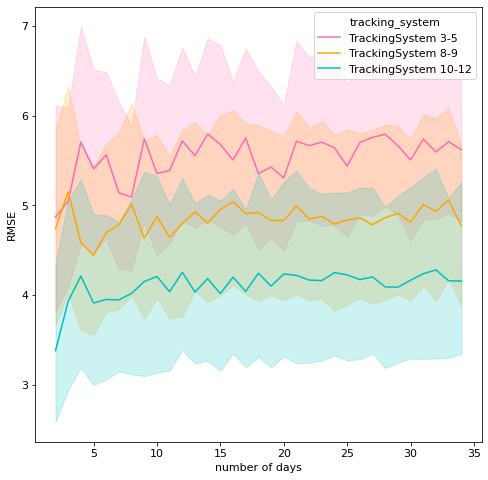

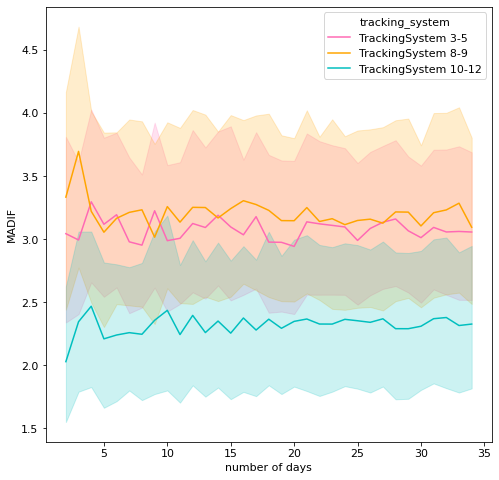

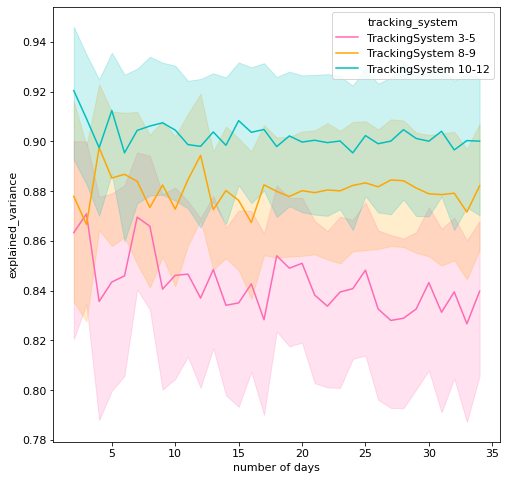

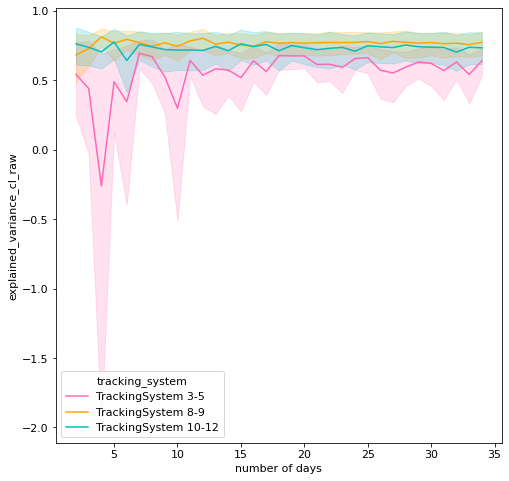

In [62]:
#define color of the hen depending on the median of it total nbr of transition over the overall period
for y in ['RMSE','MAE','explained_variance','explained_variance_cl_raw']:
    plt.figure(figsize=(8,8))
    df_impact['tracking_system'] = df_impact['tracking_system'].astype('category')
    hue_order = ['TrackingSystem 3-5','TrackingSystem 8-9','TrackingSystem 10-12']
    sns.lineplot(data=df_impact, y=y, x='number of days', hue='tracking_system', legend='full', hue_order=hue_order,
                 palette=pal_tracking_system); 
    plt.ylabel(y.replace('MAE','MADIF'))
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'IndividualBehaviouralImpact_perTrackingsystem'+y+'.png'), 
                format='png', bbox_inches='tight', dpi=300)

### pen

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


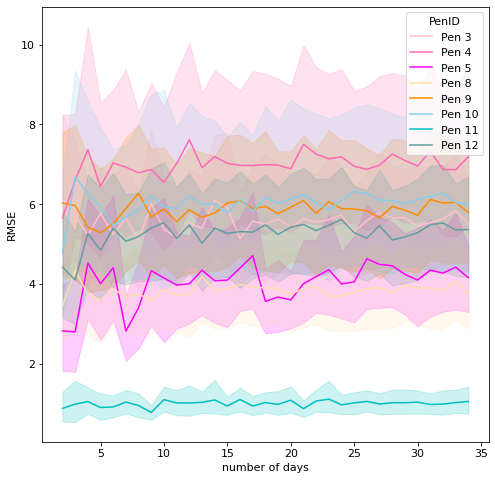

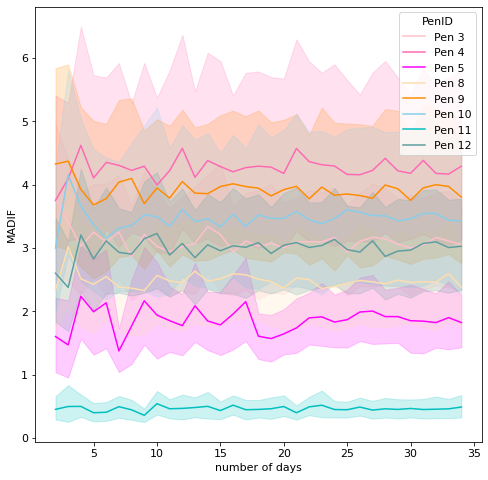

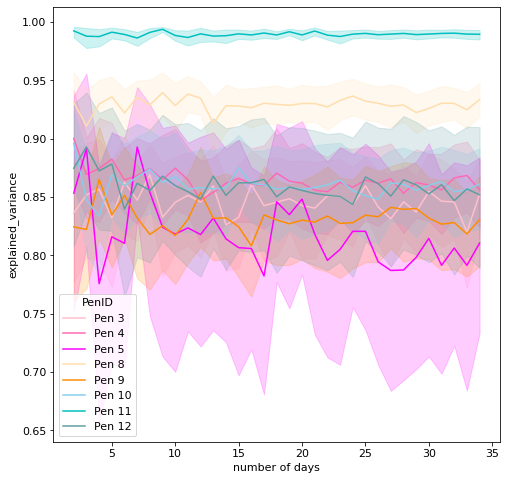

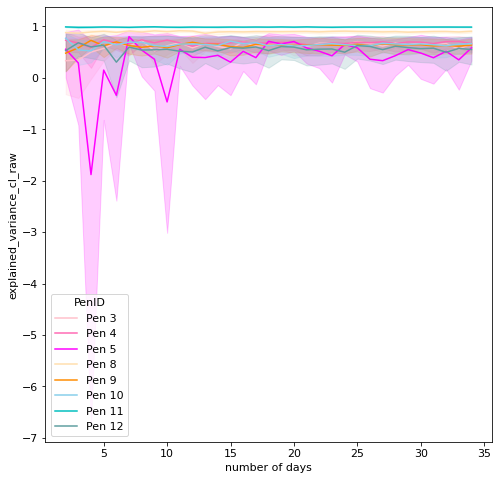

In [63]:
#define color of the hen depending on the median of it total nbr of transition over the overall period
for y in ['RMSE','MAE','explained_variance','explained_variance_cl_raw']:
    plt.figure(figsize=(8,8))
    df_impact['PenID'] = df_impact['PenID'].astype('category')
    hue_order = ['Pen 3', 'Pen 4', 'Pen 5', 'Pen 8', 'Pen 9', 'Pen 10', 'Pen 11', 'Pen 12']
    sns.lineplot(data=df_impact, y=y, x='number of days', hue='PenID', legend='full', hue_order=hue_order, palette=pal_pens); 
    plt.ylabel(y.replace('MAE','MADIF'))
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'IndividualBehaviouralImpact_perPen'+y+'.png'), 
                format='png', bbox_inches='tight', dpi=300)

### hen

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


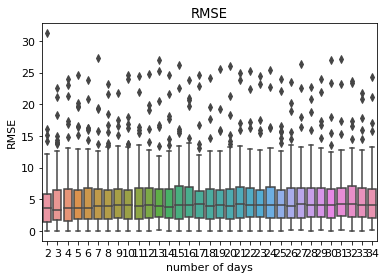

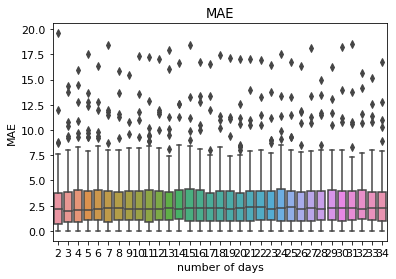

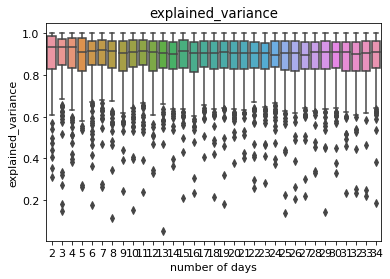

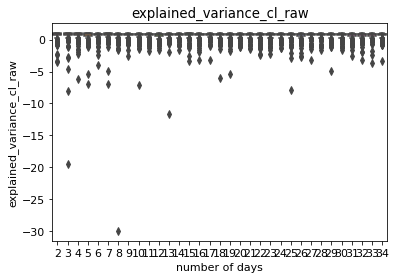

In [17]:
for y in ['RMSE','MAE','explained_variance','explained_variance_cl_raw']:
    sns.boxplot(data=df_impact, y=y, x='number of days')
    plt.title(y)
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'IndividualBehaviouralImpact_'+y+'.png'), 
            format='png', bbox_inches='tight', dpi=300)
    plt.show();
#--> the variation of the mean absolut error over all chicken does not not reduce over time.

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-27-5b7ecc7368c4>:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = DivergingNorm(vmin=min(dico_hen_mvt.values()), vcenter=np.mean(list(dico_hen_mvt.values())),
<ipython-input-27-5b7ecc7368c4>:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = DivergingNorm(vmin=min(dico_hen_mvt.values()), vcenter=np.mean(list(dico_hen_mvt.values())),
<ipython-input-27-5b7ecc7368c4>:8: MatplotlibDep

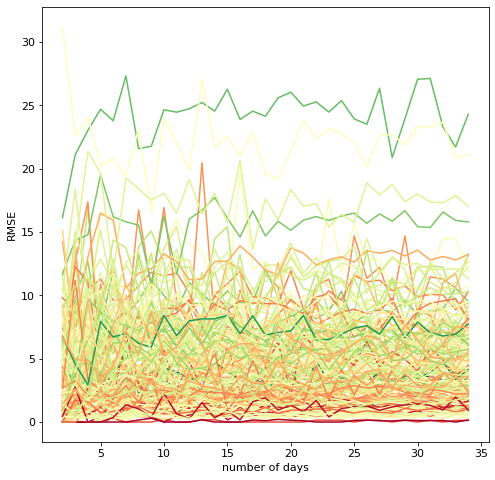

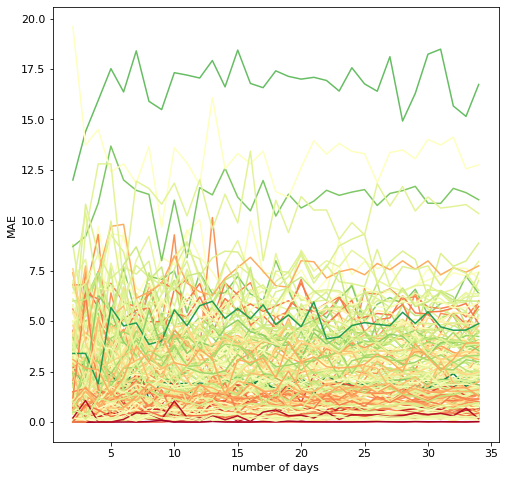

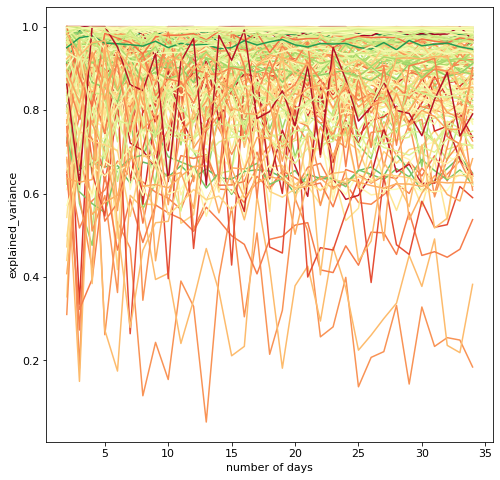

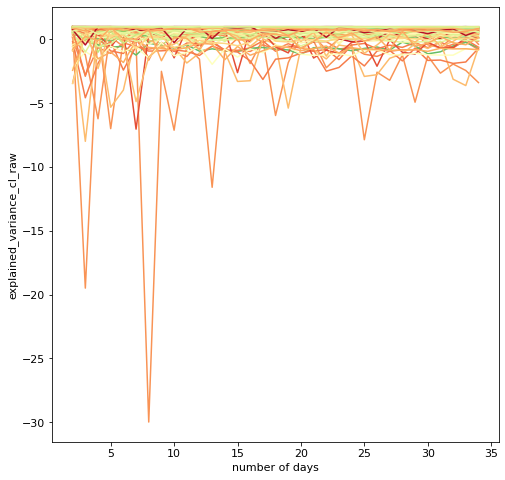

In [27]:
#define color of the hen depending on the median of it total nbr of transition over the overall period
for y in ['RMSE','MAE','explained_variance','explained_variance_cl_raw']:
    df_ = df_var[df_var['type']=='cleaning'][['HenID','Total_number_transition']]
    df_ = df_[~df_.isnull().any(axis=1)]
    dico_hen_mvt = dict(df_.groupby(['HenID'])['Total_number_transition'].agg(lambda x: round(np.median(x),0)))
    len(dico_hen_mvt.values()), len(set(dico_hen_mvt.values()))
    norm = DivergingNorm(vmin=min(dico_hen_mvt.values()), vcenter=np.mean(list(dico_hen_mvt.values())), 
                         vmax=max(dico_hen_mvt.values()))
    colors = {h:plt.cm.RdYlGn(norm(mvt)) for h,mvt in dico_hen_mvt.items()}
    plt.figure(figsize=(8,8))
    df_impact['HenID'] = df_impact['HenID'].astype('category')
    hue_order = np.sort(df_impact['HenID'].unique())
    sns.lineplot(data=df_impact, y=y, x='number of days', hue='HenID', palette=colors, legend=False, hue_order=hue_order); 
    #check legend for verification (done)
    #--> some chicken always have a low R2. THis score does not depend on the total amount of transitions!!
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'IndividualBehaviouralImpact_perhen'+y+'.png'), 
                format='png', bbox_inches='tight', dpi=300)

#hens with most error
plt.figure(figsize=(15,8))
li_hen2plt = df_impact[df_impact['explained_variance']<0.4]['HenID'].tolist()
colors = {h:plt.cm.RdYlGn(norm(mvt)) for h,mvt in dico_hen_mvt.items() if h in li_hen2plt}
sns.lineplot(data=df_impact[df_impact['HenID'].isin(li_hen2plt)], y='explained_variance', x='number of days', hue='HenID', 
             palette=colors);
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 
                         'MostProblematicHens_BehaviouralImpact_explained_variance.png'),
            format='png', bbox_inches='tight', dpi=300)

In [19]:
#redish: low number of transition
li_hen2plt = ['hen_145','hen_146', 'hen_39', 'hen_26', 'hen_93']
li_tr = df_var[(df_var['HenID'].isin(li_hen2plt))&(df_var['type']=='cleaning')]['Total_number_transition'].tolist()
li_tr = [x for x in li_tr if not math.isnan(x)]
print(np.mean(li_tr), np.median(li_tr), min(li_tr))
li_tr = df_var[(~df_var['HenID'].isin(li_hen2plt))&(df_var['type']=='cleaning')]['Total_number_transition'].tolist()
li_tr = [x for x in li_tr if not math.isnan(x)]
print(np.mean(li_tr), np.median(li_tr), min(li_tr))
#--> is not due to: more mvt, induce more errors

11.56060606060606 9.0 0.0
58.63803182851575 59.0 0.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#greenish: high nbr of transition
li_hen2plt = ['hen_122']
li_tr = df_var[(df_var['HenID'].isin(li_hen2plt))&(df_var['type']=='cleaning')]['Total_number_transition'].tolist()
li_tr = [x for x in li_tr if not math.isnan(x)]
print(np.mean(li_tr), np.median(li_tr), min(li_tr))
li_tr = df_var[(~df_var['HenID'].isin(li_hen2plt))&(df_var['type']=='cleaning')]['Total_number_transition'].tolist()
li_tr = [x for x in li_tr if not math.isnan(x)]
print(np.mean(li_tr), np.median(li_tr), min(li_tr))
#--> is not due to: more mvt, induce more errors

126.6875 127.5 41.0
56.73123812539582 57.0 0.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
li_tr = df_var[(df_var['HenID'].isin(li_hen2plt))&(df_var['type']=='cleaning')]['Total_number_transition'].tolist()
li_tr = [x for x in li_tr if not math.isnan(x)]
print(np.mean(li_tr), np.median(li_tr), min(li_tr))
li_tr = df_var[(~df_var['HenID'].isin(li_hen2plt))&(df_var['type']=='cleaning')]['Total_number_transition'].tolist()
li_tr = [x for x in li_tr if not math.isnan(x)]
print(np.mean(li_tr), np.median(li_tr), min(li_tr))
#--> is not due to: more mvt, induce more errors

126.6875 127.5 41.0
56.73123812539582 57.0 0.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Difference & ExplainedVariance over single days per chicken
#NOTE: does not make sense to do per class_cleaning_mvt values, as we want the score when taking all variation into account,
#same logic as way reliability of HA might never be reliable on single days, but will be overall!!!
df_ = df_var[['HenID','level','type','Total_number_transition']]
df_ = df_[~df_.isnull().any(axis=1)]
max_nbr_days = 35
dico_hen_days = dict(df_.groupby(['HenID'])['level'].count())
li_hen = [h for h,nbrdays in dico_hen_days.items() if nbrdays>max_nbr_days]
#print('We have %s hens with at least %s days'%(len(li_hen), max_nbr_days))
df_ = df_[df_['HenID'].isin(li_hen)]
#remove all hens with less than this amount of days
#display(df_.head(3))
df__ = df_.pivot(index=['HenID','level'], columns='type', values='Total_number_transition').reset_index()
#display(df__.head(3))
df__['class_cleaning_mvt'] = df__['cleaning'].map(lambda x: round(x/100,1)*100) #30:[26,35]
#display(df__.head(3))
li1 = df__['raw']
li2 = df__['cleaning']
#R2 = r2_score(li1, li2)
explained_variance = explained_variance_score(li1, li2)
print('The overall explained variance over the total number of transition per chicken per day is: %.2f'%explained_variance)

### zone

In [44]:
#at each day the percentage of wrong transition
#to avoid impact of time on the mvt of the chicken, we will selcted the days randomly across all possible days, and do several
#such plot to see if the patterns is still the same, but we dont aggregate all as the more the nbr of days increase, the least
#possibilities exists, and hence less variation by definition
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
df_ = df_var[['HenID','level','type']+li_var]
df_ = df_[~df_.isnull().any(axis=1)]
li_all_date = df_['level'].tolist()
max_nbr_days = 35
#remove all hens with less than this amount of days
display(df_.head(3))
li_df = []
for nbr_days in tqdm.tqdm(range(2,max_nbr_days)):
    for zone in li_var: 
        #select random days without repeating elements
        li_date = random.sample(li_all_date, nbr_days)
        df__ = df_[df_['level'].isin(li_date)]
        #put the type (raw and cleaning) into columns
        df__ = df__.pivot(index=['HenID','level'], columns='type', values=zone).reset_index()
        #display(df__.head(3))
        li1 = df__['raw']
        li2 = df__['cleaning']
        #symetric
        RMSE = math.sqrt(mean_squared_error(li1, li2))
        MAE = mean_absolute_error(li1, li2)
        #not symmetric attention
        #R2 = r2_score(li1, li2) #should be y_true, y_pred
        explained_variance = explained_variance_score(li1, li2) #should be y_true, y_pred
        explained_variance_ = explained_variance_score(li2, li1) #should be y_true, y_pred
        li_df.append({'Trackingsystem_Zone':zone, 'RMSE': RMSE, 'MAE':MAE, 'explained_variance':explained_variance,
                      'explained_variance_cl_raw':explained_variance_,
                      'number of days':nbr_days, 'li_date':li_date, 'nbrObservations':len(li1)})
df_impact_zone = pd.DataFrame(li_df)
print(df_impact_zone.shape)
df_impact_zone.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,type,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
0,hen_131,2020-10-27,cleaning,8.0,24.0,25.0,9.0,1.0
1,hen_131,2020-10-28,cleaning,9.0,25.0,19.0,4.0,1.0
2,hen_131,2020-10-29,cleaning,8.0,25.0,29.0,13.0,2.0


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 23.03it/s]

(165, 8)


,Trackingsystem_Zone,RMSE,MAE,explained_variance,explained_variance_cl_raw,number of days,li_date,nbrObservations
0,nbr_stays_1_Zone,4.189478,1.376176,0.587729,-0.625009,2,"[2021-01-11 00:00:00, 2020-12-12 00:00:00]",319
1,nbr_stays_2_Zone,7.679717,4.721003,0.809214,0.682045,2,"[2020-12-12 00:00:00, 2020-11-13 00:00:00]",319
2,nbr_stays_3_Zone,8.887444,5.066667,0.768599,0.614187,2,"[2020-11-07 00:00:00, 2020-12-07 00:00:00]",300


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


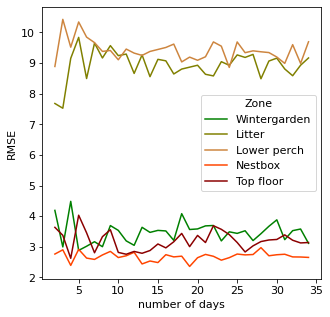

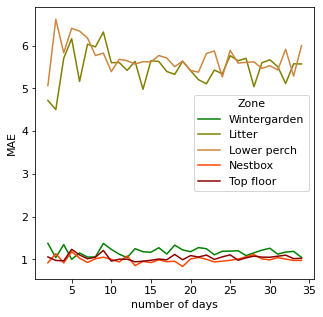

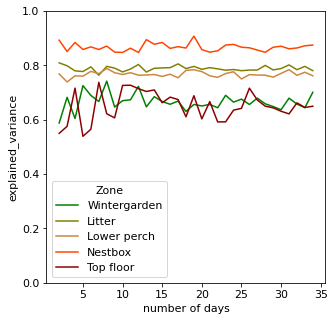

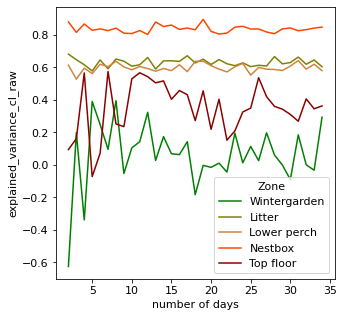

In [48]:
#define color of the hen depending on the median of it total nbr of transition over the overall period
dico_name_z = {'nbr_stays_1_Zone':'Wintergarden', 'nbr_stays_2_Zone':'Litter', 'nbr_stays_3_Zone':'Lower perch', 
            'nbr_stays_4_Zone':'Nestbox', 'nbr_stays_5_Zone':'Top floor'}
for y in ['RMSE','MAE','explained_variance','explained_variance_cl_raw']:
    plt.figure(figsize=(5,5))
    df_impact_zone['Zone'] = df_impact_zone['Trackingsystem_Zone'].map(lambda x: dico_name_z[x])
    df_impact_zone['Zone'] = df_impact_zone['Zone'].astype('category')
    hue_order = ['Wintergarden', 'Litter', 'Lower perch', 'Nestbox', 'Top floor']
    if y=='explained_variance':
        plt.ylim(0,1)
    sns.lineplot(data=df_impact_zone, y=y, x='number of days', hue='Zone', legend='full', hue_order=hue_order,
                palette=pal_zone); 
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'IndividualBehaviouralImpact_perZone'+y+'.png'), 
                format='png', bbox_inches='tight', dpi=300)

# Scatter plot: behavioural variables OVER ENTIRE PERIOD

In [60]:
#display(list((df_var.columns)))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------------------------------ winter garden
Max_duration_WG


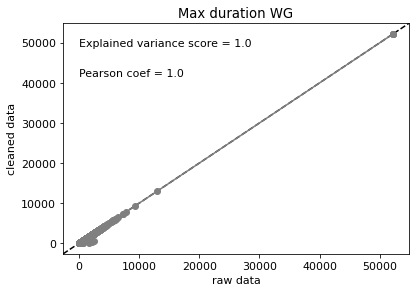

in_WG_15mnAfterOpening


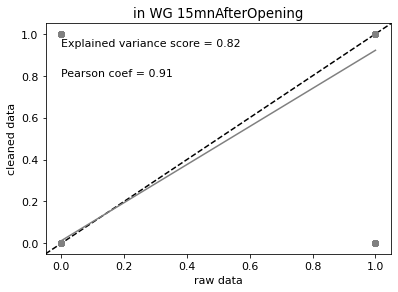

------------------------------ duration
duration_1_Zone


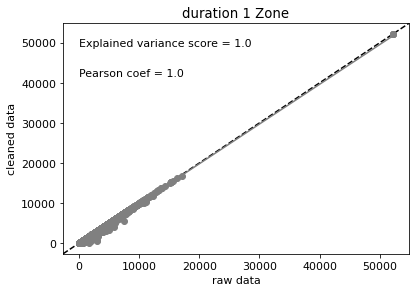

duration_2_Zone


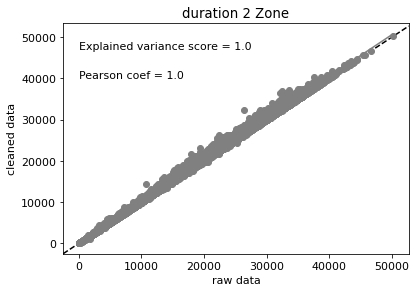

duration_3_Zone


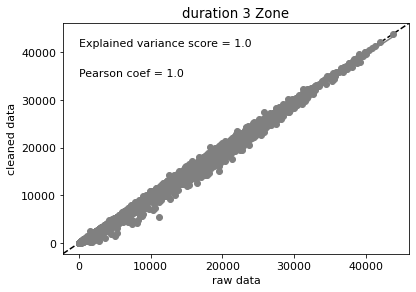

duration_4_Zone


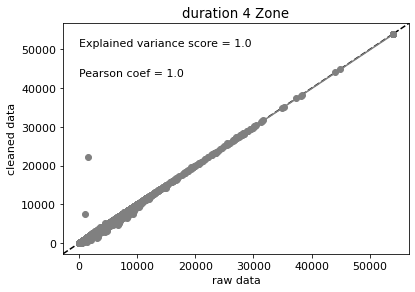

duration_5_Zone


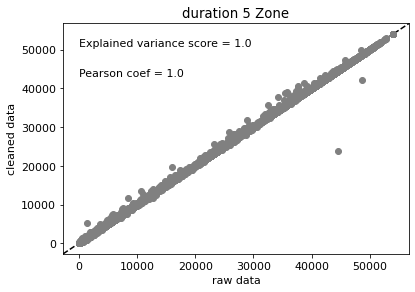

mean_duration


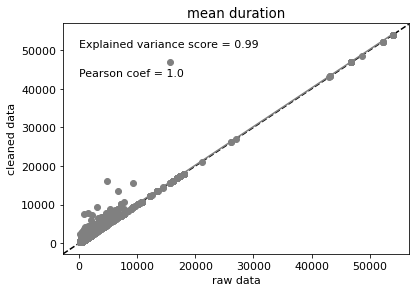

median_duration


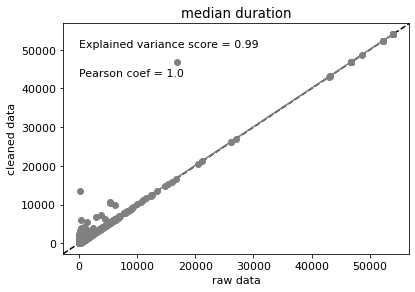

variance_duration


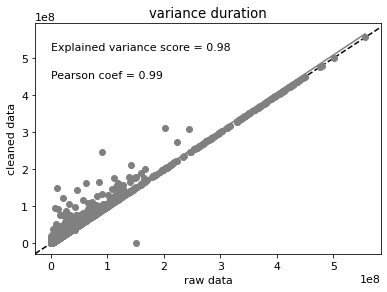

max_duration


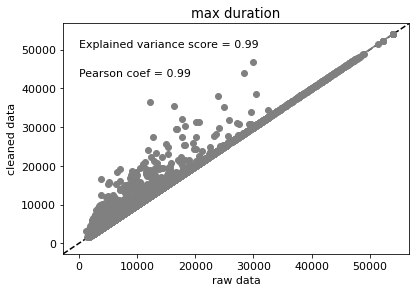

------------------------------ activity
night_Total_number_transition


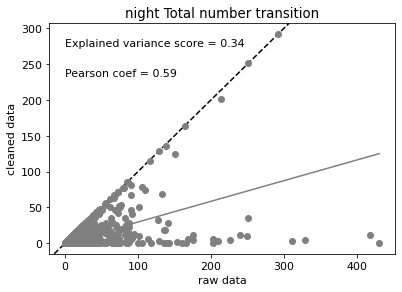

vertical_travel_distance


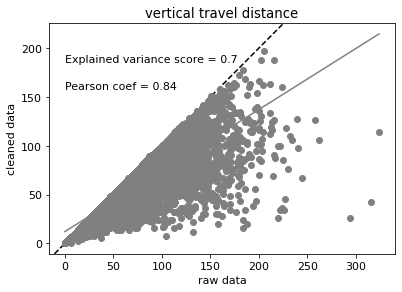

------------------------------ chaotic
chaoticmvt_Middle1_Zone_nbr_180mn


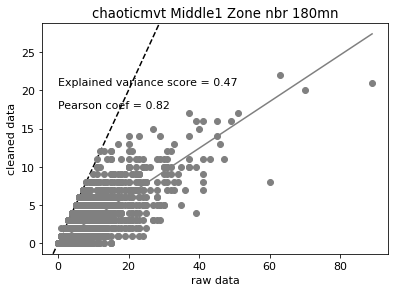

chaoticmvt_Middle2_Zone_nbr_180mn


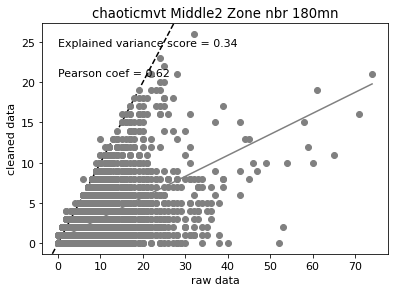

chaoticmvt_Middle3_Zone_nbr_180mn


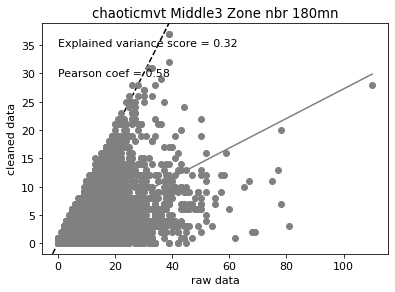

chaoticmvt_Middle4_Zone_nbr_180mn


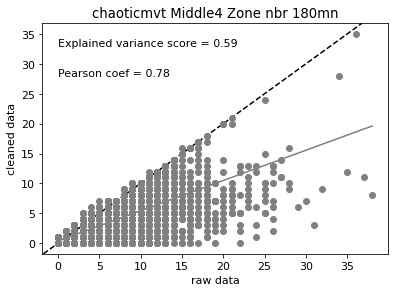

chaoticmvt_Middle5_Zone_nbr_180mn


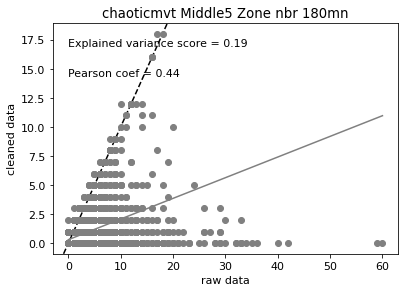

------------------------------ more complexe variables
distribution_entropy


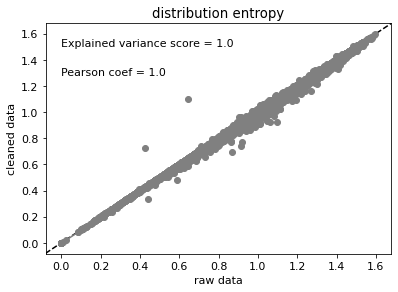

sucessIntrusion_9


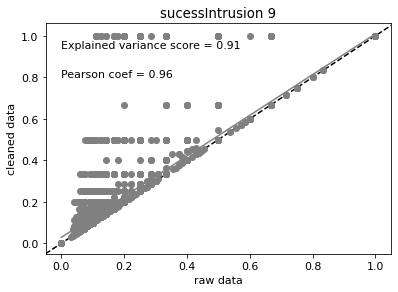

down_missingZone_mvtPerc


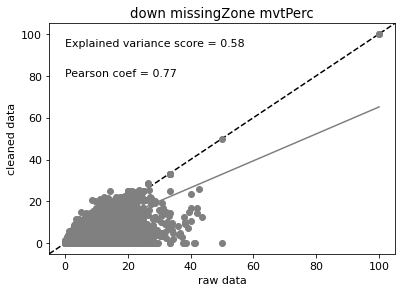

up_missingZone_mvtPerc


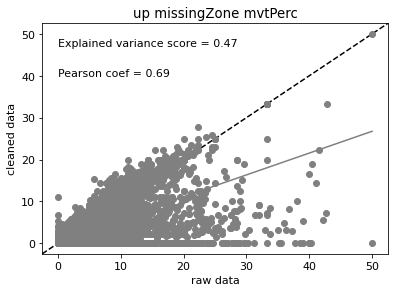

In [74]:
#define color of the hen depending on the median of it total nbr of transition over the overall period
dico_ = {'winter garden': ['Max_duration_WG', 'in_WG_15mnAfterOpening'],
         'duration':['duration_1_Zone','duration_2_Zone','duration_3_Zone','duration_4_Zone','duration_5_Zone',
                    'mean_duration','median_duration','variance_duration','max_duration'],
         'activity':['night_Total_number_transition','vertical_travel_distance'],
         'chaotic':['chaoticmvt_Middle1_Zone_nbr_180mn','chaoticmvt_Middle2_Zone_nbr_180mn',
                    'chaoticmvt_Middle3_Zone_nbr_180mn','chaoticmvt_Middle4_Zone_nbr_180mn','chaoticmvt_Middle5_Zone_nbr_180mn'],
         'more complexe variables':['distribution_entropy','sucessIntrusion_9',
                                    'down_missingZone_mvtPerc','up_missingZone_mvtPerc']}
for name_,li_v in dico_.items():  
    print('------------------------------', name_)
    for y_ in li_v:
        print(y_)
        ############### Computation
        #data: one colomn for the rawand one for the cleaned
        df_plt = df_var[['HenID','level', 'type', y_]].copy()
        if y_ in ['in_WG_15mnAfterOpening']:
            df_plt.dropna(inplace=True)
            df_plt['in_WG_15mnAfterOpening'] = df_plt['in_WG_15mnAfterOpening'].map(lambda x: int(x))
        df_plt = df_plt.pivot(index=['HenID','level'], columns='type',values=y_).reset_index()
        #print(df_plt.shape)
        df_plt = df_plt[~df_plt.isnull().any(axis=1)]
        #print(df_plt.shape)
        #display(df_plt.head(3))        
        x = np.array(df_plt['raw'].tolist())
        y = np.array(df_plt['cleaning'].tolist())

        #measures
        Explvarscore = explained_variance_score(x, y)
        RMSE = math.sqrt(mean_squared_error(x, y))
        MAE = mean_absolute_error(x, y)
        rcoeff2, p_value2 = pearsonr(x, y)

        #linear model & it's the 95% CI
        slope, intercept = np.polyfit(x, y, 1) #degree=1: fit a linear model
        y_model = np.polyval([slope, intercept], x) #evaluate the y_pred by the model
        x_mean = np.mean(x) ; y_mean = np.mean(y)
        n = x.size                        # number of samples
        dof = n - 2                       # degrees of freedom: size-#parameters
        t_ = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
        residual = y - y_model

        ############### Plot
        plt.rcParams.update({'font.size': 11})
        fig = plt.figure()
        ax = fig.add_axes([.1, .1, .8, .8])

        #plot points with size equal to the amount of points (as count data)
        # count the occurrences of each point
        #c = Counter(zip(x,y))
        # create a list of the sizes, here multiplied by 10 for scale
        #s = [10*c[(xx,yy)] for xx,yy in zip(x,y)]
        #ax.scatter(x, y, s=s, color = 'royalblue')
        ax.scatter(x, y, color = 'grey')

        #plot middle line and 95% IC
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = np.polyval([slope, intercept], x_line)
        ax.plot(x_line, y_line, color = 'grey')

        #add text
        ax.set_xlabel('raw data')
        ax.set_ylabel('cleaned data')
        plt.title(y_.replace('_',' '))
        ax.text(0, max(y)-0.06*max(y), 'Explained variance score = ' + str(np.round(Explvarscore,2)))
        if p_value2<=0.05:
            ax.text(0, max(y)-0.20*max(y), 'Pearson coef = ' + str(np.round(rcoeff2,2)))
        else:
            print('NO SIGNIFICANT PVALUE')

        #add diagonal line
        ax.axline((0, 0), slope=1, c="black", ls="--", zorder=0)

        #save and show
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, "Behavioural_Variable_"+y_+".png"),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show();

# Visualise the MLP's differences

In [ ]:
#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, id_run+'_Rawdata&Model.csv'), sep=';', 
                 parse_dates=['Timestamp','date'], dayfirst=True) 
print(df.shape)
df.head(3)

In [ ]:
START_TIME = time.perf_counter()
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,11,1)
dmax = dt.datetime(2020,11,9)
#df_ = df[(df['date']<dt.datetime(2020,11,16))&(df['date']>dt.datetime(2020,11,10))]
df_ = df[(df['date']<=dmax)&(df['date']>=dmin)].copy()
#only print the hens with at least one transition per day (simplicity and interestignly)
#to sort the yaxis
dico_zone_order = {'1_Zone':0, '2_Zone':1, '3_Zone':2, '4_Zone':3, '5_Zone':4}
li_ts = ['Trackingsystem_Zone','Model_Zone']
li_date = df_['date'].unique()
#for each batch draw 2 timeseries, the raw one and the model one
for henID, df_plt in tqdm.tqdm(df_.groupby(['HenID'])):
    df_plt = df_plt.sort_values(['Timestamp']).copy()
    c = len(li_ts) ; l = len(li_date)
    fig, ax = plt.subplots(figsize=(c*5, l*1))
    i = 1
    if len(df_plt['date'].unique())==len(li_date):
        mi = min(df_plt['Timestamp'].tolist()) ; ma = max(df_plt['Timestamp'].tolist())
        Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                                  end = ma-dt.timedelta(seconds=(ma.second+1)), 
                                  freq = 'S') 
        df_plt_ = df_plt.copy()
        df_plt_.set_index('Timestamp', inplace=True)
        df_plt_ = df_plt_.reindex(Daterange, method='ffill').reset_index()
        df_plt_.rename(columns={'index':'Timestamp'}, inplace=True)
        #add date again, as the reindexing also extended the date
        df_plt_['date'] = df_plt_['Timestamp'].map(lambda x: dt.datetime.date(x))
        #remove first & last date
        df_plt_ = df_plt_[~df_plt_['date'].isin([max(df_plt_['date'].tolist()),min(df_plt_['date'].tolist())])]
        #put xlabel into numbers for the ploting
        df_plt_['Trackingsystem_Zone'] = df_plt_['Trackingsystem_Zone'].map(lambda x: int(dico_zone_order[x]))       
        for d, df_plt__ in df_plt_.groupby(['date']):
            for v in li_ts:
                df_plt___ = df_plt__.copy()
                if v=='Model_Zone':
                    df_plt___ = df_plt___[df_plt___['model_prediction']==1]
                plt.subplot(l,c,i)
                plt.tight_layout(pad=0.3) #add spacing between each plot
                if i%2==1:
                    plt.yticks([0,1,2,3,4], ['Winter garden', 'Litter', 'Lower perch','Nestbox','Top floor'])#, rotation='vertical')
                else:
                    plt.yticks([0,1,2,3,4], ['','','','',''])
                if i in [1,2]:
                    plt.title(v.replace('_',' '), size=13)
                i = i+1
                plt.plot(df_plt___['Timestamp'].tolist(), df_plt___['Trackingsystem_Zone'].tolist(), 
                         color=pal_[v], linewidth=1)
                li_hour = pd.date_range(start = d,  end = d+dt.timedelta(days=1), freq = 'H')
                plt.xticks(li_hour , [str(i.hour)+'h' for i in li_hour], fontsize=5)                
                plt.yticks(fontsize=8)
                plt.xlabel(str(d).split('T')[0], size=7)
                plt.ylim(0, 4.2)  
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 
                                 henID+'_'+str(dmin).split(' ')[0]+'_'+str(dmax).split(' ')[0]+'.png'), 
                    format='png', bbox_inches='tight', dpi=300)
    plt.clf()
    plt.close("all")    
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
#hen4, 22.10.2020: flickering. solved?